# Employee Attrition Prediction using XGBoost 

This notebook shows a **complete, end-to-end example** of using XGBoost to predict employee attrition on the **IBM HR Analytics Employee Attrition & Performance** dataset (Kaggle). Each row is an employee, and the goal is to predict whether they are likely to **leave the company** (`Attrition = Yes`) based on demographic, job, and satisfaction features.

We follow the main project requirements:

- **EDA (Exploratory Data Analysis)**  
  - Look at overall attrition rates  
  - Explore patterns by **age group**, **job role**, **work–life balance**, **overtime**, and **monthly income**

- **Preprocessing**  
  - Split features and target (`Attrition`)  
  - One-hot encode categorical variables  
  - Scale numeric features  
  - Build a reusable `ColumnTransformer + Pipeline` so all models share the same preprocessing

- **Model Training (XGBoost)**  
  - Train an `XGBClassifier` to predict attrition  
  - Handle **class imbalance** using `scale_pos_weight`  
  - Wrap XGBoost in a scikit-learn pipeline for clean training and prediction

- **Evaluation**  
  - Measure **Accuracy**, **F1-score**, and **ROC-AUC** on a held-out test set  
  - Show the **confusion matrix** and **ROC curve**  
  - Perform **threshold tuning** to trade off F1 vs recall for the “Attrition = Yes” class

- **Interpretability**  
  - Use XGBoost’s **feature importances** to see which variables matter most  
  - Use **SHAP values** to understand how features push predictions higher or lower for attrition

- **Bonus Comparisons**  
  - Train and compare **Logistic Regression** and **Random Forest** (with class weighting) against XGBoost  
  - Summarize which model performs best and why XGBoost is a good choice for this tabular prediction problem

This notebook is meant to be a **compact demonstration** of the API layer and workflow used in the main Employee Attrition project, not a full report.


### 1. Import libraries and set up plotting style

In this cell, we import all the Python libraries needed for the project:
- `pandas`, `numpy` for data handling and calculations  
- `matplotlib`, `seaborn` for visualizations  
- `scikit-learn` tools for preprocessing, model building, and evaluation  
- `xgboost` for the main classifier  
- `shap` for model interpretability  
- `kagglehub` to download the IBM HR dataset from Kaggle  

We also set a simple global plot style to make all charts look consistent.


In [18]:
# Install packages if needed (uncomment and run once)
# !pip install kagglehub xgboost shap scikit-learn pandas matplotlib seaborn

# Core libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Kaggle dataset download
import kagglehub

# Scikit-learn: preprocessing, modeling pipeline, and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Main model and explainability
from xgboost import XGBClassifier
import shap

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)




### 2. Load the dataset via KaggleHub 



In this cell, we download the IBM HR Analytics dataset from Kaggle using `kagglehub`, point to the main CSV file, load it into a pandas DataFrame, and quickly check its shape and first few rows.


In [19]:


# Download dataset from Kaggle
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")
print("Folder where KaggleHub downloaded the files:", path)

# The CSV file name inside the folder
csv_path = os.path.join(path, "WA_Fn-UseC_-HR-Employee-Attrition.csv")

# If you already have the CSV in the same folder as the notebook, you could do:
# csv_path = "WA_Fn-UseC_-HR-Employee-Attrition.csv"

df = pd.read_csv(csv_path)

print("Shape of the dataset:", df.shape)
df.head()


Folder where KaggleHub downloaded the files: /Users/tchandrasekaran/.cache/kagglehub/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/versions/1
Shape of the dataset: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### 3. Check the basic structure of the dataset

3.1 Here we inspect the DataFrame structure (columns, data types, and non-null counts) to understand what kind of features we have and whether there are any missing values.


In [20]:
# Structure of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

3.2 This cell shows basic descriptive statistics (mean, std, min, max, quartiles) for all numeric columns to get a quick sense of their ranges and distributions.

In [21]:
# Basic statistics for numeric columns
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


3.3 Here we look at how many employees stayed vs left, both in raw counts and percentages, to see how imbalanced the Attrition classes are.

In [22]:
# Count how many employees have Attrition = Yes / No
attr_counts = df["Attrition"].value_counts()

# Compute percentage distribution of the target
attr_percent = df["Attrition"].value_counts(normalize=True) * 100

print("Attrition counts:\n", attr_counts)
print("\nAttrition percentage (%):\n", attr_percent.round(2))



Attrition counts:
 Attrition
No     1233
Yes     237
Name: count, dtype: int64

Attrition percentage (%):
 Attrition
No     83.88
Yes    16.12
Name: proportion, dtype: float64


### 4. EDA – Attrition overall & by age, job role, work–life balance

#### 4.1 Overall attrition distribution

This plot shows how many employees left (Attrition = Yes) vs stayed (Attrition = No), so we can visually see the class imbalance.


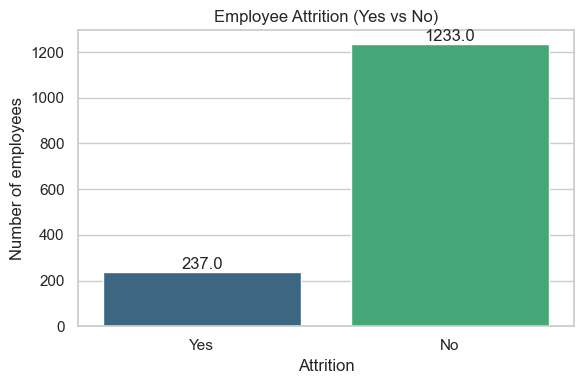

In [23]:
# Colorful bar plot of Attrition = Yes vs No (no FutureWarning)
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    data=df,
    x="Attrition",
    hue="Attrition",      # tie colors to the x variable
    palette="viridis",
    legend=False          # legend would be redundant here
)

plt.title("Employee Attrition (Yes vs No)")
plt.xlabel("Attrition")
plt.ylabel("Number of employees")

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()




Heavily imbalanced: 1,233 employees stayed and only 237 left.

#### 4.2 Attrition by age group

In this step, we group employees into age bands and calculate the attrition rate within each band. This helps us see which age groups are more likely to leave.


  AgeBin  AttritionFlag
0  18–25       0.357724
1  26–35       0.191419
2  36–45       0.091880
3  46–55       0.115044
4    56+       0.170213


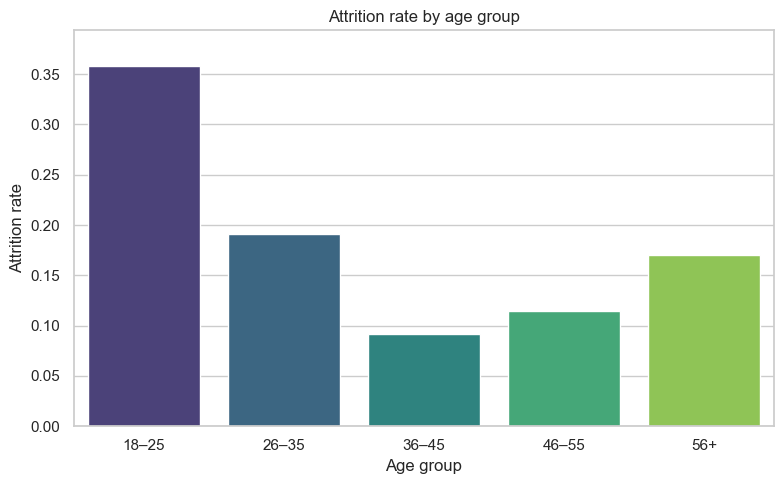

In [24]:
# Create age groups (bins)
df["AgeBin"] = pd.cut(
    df["Age"],
    bins=[17, 25, 35, 45, 55, 70],
    labels=["18–25", "26–35", "36–45", "46–55", "56+"]
)

# Numeric flag for Attrition (1 = Yes, 0 = No)
df["AttritionFlag"] = df["Attrition"].map({"Yes": 1, "No": 0})

# Compute average attrition rate per age group
age_attrition = (
    df.groupby("AgeBin", observed=False)["AttritionFlag"]  
      .mean()
      .reset_index()
)

print(age_attrition)

# Bar plot of attrition rate by age group 
plt.figure(figsize=(8, 5))
sns.barplot(
    data=age_attrition,
    x="AgeBin",
    y="AttritionFlag",
    hue="AgeBin",       
    palette="viridis",
    legend=False
)
plt.ylabel("Attrition rate")
plt.xlabel("Age group")
plt.title("Attrition rate by age group")
plt.ylim(0, age_attrition["AttritionFlag"].max() * 1.1)  # add a bit of headroom
plt.tight_layout()
plt.show()





The results show that younger employees (18–25, then 26–35) have the highest attrition rates, while mid-career employees (36–45) are the least likely to leave, with older groups in between.

#### 4.3 Attrition by Job Role

Here we calculate the attrition rate for each job role and sort them from highest to lowest. This helps identify which roles are more likely to lose employees.


                     JobRole  AttritionFlag
0       Sales Representative       0.397590
1      Laboratory Technician       0.239382
2            Human Resources       0.230769
3            Sales Executive       0.174847
4         Research Scientist       0.160959
5     Manufacturing Director       0.068966
6  Healthcare Representative       0.068702
7                    Manager       0.049020
8          Research Director       0.025000


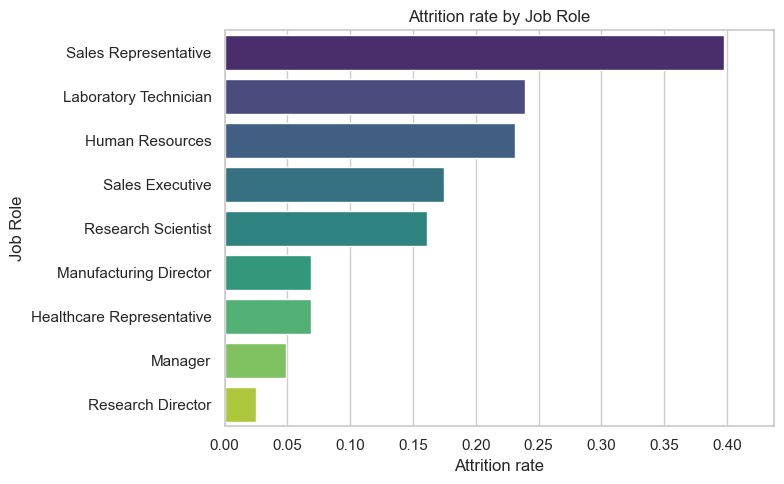

In [25]:
# Compute average attrition rate per Job Role, sorted descending
role_attrition = (
    df.groupby("JobRole", observed=False)["AttritionFlag"]   # add observed=False
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

print(role_attrition)

# Colorful horizontal bar plot of attrition rate by Job Role (no FutureWarning)
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=role_attrition,
    x="AttritionFlag",
    y="JobRole",
    hue="JobRole",     
    palette="viridis",
    legend=False       
)

plt.xlabel("Attrition rate")
plt.ylabel("Job Role")
plt.title("Attrition rate by Job Role")
plt.xlim(0, role_attrition["AttritionFlag"].max() * 1.1)

plt.tight_layout()
plt.show()




From the output, we see roles like Sales Representative have the highest attrition rates, while senior roles such as Research Director and Manager are much more stable.

#### 4.4 Attrition vs Work–Life Balance

We map the numeric work–life balance scores (1–4) to labels and compute the attrition rate for each level. This shows how better work–life balance is related to lower attrition.


  WorkLifeBalanceLabel  AttritionFlag
0                  Bad       0.312500
1                 Best       0.176471
3                 Good       0.168605
2               Better       0.142217


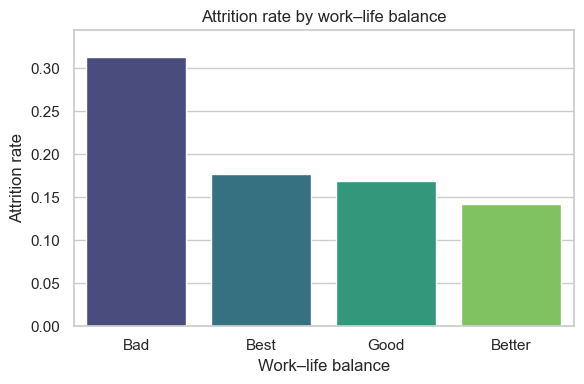

In [26]:
# Map numeric WLB scores to labels
wlb_map = {1: "Bad", 2: "Good", 3: "Better", 4: "Best"}
df["WorkLifeBalanceLabel"] = df["WorkLifeBalance"].map(wlb_map)

# Compute attrition rate for each WLB level
wlb_attrition = (
    df.groupby("WorkLifeBalanceLabel", observed=False)["AttritionFlag"]
      .mean()
      .reset_index()
      .sort_values("AttritionFlag", ascending=False)
)

print(wlb_attrition)

# Colorful bar plot of attrition rate by work–life balance (no FutureWarning)
plt.figure(figsize=(6, 4))
sns.barplot(
    data=wlb_attrition,
    x="WorkLifeBalanceLabel",
    y="AttritionFlag",
    hue="WorkLifeBalanceLabel",   
    palette="viridis",
    legend=False
)

plt.ylabel("Attrition rate")
plt.xlabel("Work–life balance")
plt.title("Attrition rate by work–life balance")
plt.ylim(0, wlb_attrition["AttritionFlag"].max() * 1.1)

plt.tight_layout()
plt.show()



The plot shows that employees who report “Bad” work–life balance have the highest attrition, while those with “Better” or “Best” balance are less likely to leave.

#### 4.5 Attrition vs OverTime and Monthly Income

In this step, we:
- Compare attrition rates for employees who work overtime vs those who don’t.
- Compare the distribution of monthly income for employees who stayed vs those who left.
This helps us see whether overtime and pay level are related to attrition.



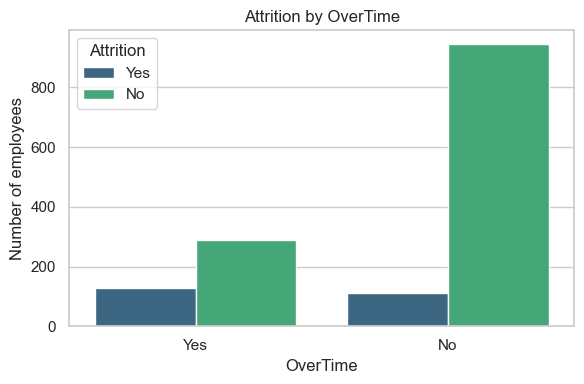

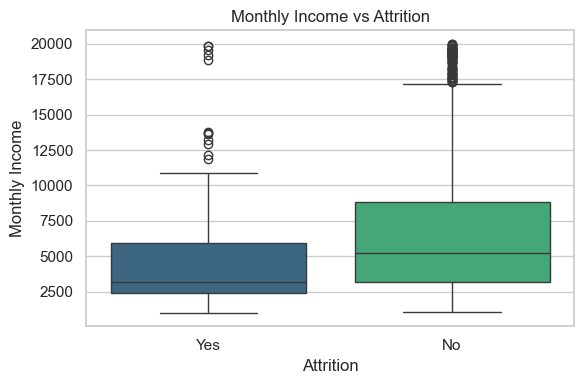

In [27]:
# Attrition split by OverTime status
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    data=df,
    x="OverTime",
    hue="Attrition",
    palette="viridis"
)
plt.title("Attrition by OverTime")
plt.xlabel("OverTime")
plt.ylabel("Number of employees")
plt.tight_layout()
plt.show()

# Monthly income distribution for Attrition = Yes vs No 
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="Attrition",
    y="MonthlyIncome",
    hue="Attrition",      
    palette="viridis",
    dodge=False,          # keep one box per group
    legend=False          # legend would repeat x-axis labels
)
plt.title("Monthly Income vs Attrition")
plt.xlabel("Attrition")
plt.ylabel("Monthly Income")
plt.tight_layout()
plt.show()






Attrition by OverTime: Shows that employees who work overtime have a higher share of leavers compared to those who don’t.

Monthly Income vs Attrition: Shows that employees who leave generally earn less per month than those who stay.

### 5. Preprocessing

### 5.1 Separate features and target

Here we create the target variable `y` (1 = employee left, 0 = stayed) and define the feature matrix `X`.  
We also drop columns that are:
- directly derived from the target (used only for EDA),
- ID-like or constant and therefore not useful for prediction.


In [28]:
# Target variable: 1 if employee left, 0 if they stayed
y = df["Attrition"].map({"Yes": 1, "No": 0})

# Drop columns that should not be used as features
X = df.drop(columns=[
    "Attrition",             # target
    "AttritionFlag",         # derived from target
    "AgeBin",                # only used for EDA
    "WorkLifeBalanceLabel"   # only used for EDA
], errors="ignore")

# Drop ID-like or constant columns that are not useful
cols_to_drop = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"]
X = X.drop(columns=[c for c in cols_to_drop if c in X.columns])

X.head()


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,...,3,1,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,...,4,4,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,...,3,2,0,7,3,3,0,0,0,0
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,...,3,3,0,8,3,3,8,7,3,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,...,3,4,1,6,3,3,2,2,2,2


5.2 Categorical vs numeric columns

In [29]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical features:", categorical_cols)
print("Numeric features:", numeric_cols)


Categorical features: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numeric features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


5.3 Train–test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,         # keep same class proportion
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))


Train size: (1176, 30)
Test size : (294, 30)
Train target distribution:
 Attrition
0    0.838435
1    0.161565
Name: proportion, dtype: float64


## 6. Build preprocessing pipelines

In [31]:
# Pipeline for categorical columns: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Pipeline for numeric columns: standard scaling
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Combine both in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols)
    ]
)


Categorical features will be one-hot encoded, and numeric features will be standard scaled.
ColumnTransformer combines both so the whole preprocessing happens automatically inside one pipeline.

### 7. XGBoost model with class imbalance handling

#### 7.1 Define XGBoost classifier with class imbalance handling

Here we calculate `scale_pos_weight` based on the ratio of non-attrition to attrition cases and pass it to XGBoost.  
This tells the model to give more weight to the minority class (Attrition = Yes).  
We then wrap the preprocessor and the XGBoost model into a single pipeline.


In [32]:
# Handle class imbalance for XGBoost:
# scale_pos_weight = (# negative examples / # positive examples)
pos = y_train.sum()                 # number of Attrition = Yes
neg = len(y_train) - pos            # number of Attrition = No
scale_pos_weight = neg / pos

print("scale_pos_weight for XGBoost:", scale_pos_weight)

# Define XGBoost classifier with class imbalance parameter
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=float(scale_pos_weight)  # more weight to Attrition = Yes
)

# Full pipeline: preprocessing + model
xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", xgb_clf)
])



scale_pos_weight for XGBoost: 5.189473684210526


### 7.2 Helper function for model evaluation

This function trains a given pipeline, prints key metrics (Accuracy, F1, ROC-AUC),  
shows a classification report and confusion matrix, and returns the scores in a dictionary.  
We will reuse it to evaluate XGBoost, Logistic Regression, and Random Forest in a consistent way.


In [33]:
def evaluate_model(name, pipeline, X_train, X_test, y_train, y_test):
    """
    Fit the given pipeline, print metrics, and return a dict with scores.
    """
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predictions & predicted probabilities on test set
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Core metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    
    # Print results
    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC-AUC  : {roc:.3f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix (rows = true, cols = predicted):\n", cm)
    
    # Return scores for later comparison
    return {
        "model": name,
        "accuracy": acc,
        "f1": f1,
        "roc_auc": roc
    }



### 7.3 Train and evaluate the XGBoost model

Here we fit the XGBoost pipeline on the training data, evaluate it on the test set using the helper function,  
and store the results in a list so we can later compare XGBoost with other models.


In [34]:
# List to store evaluation results for different models
results = []

# Train and evaluate the XGBoost pipeline
xgb_results = evaluate_model(
    "XGBoost (with class weight)",
    xgb_pipeline,
    X_train, X_test, y_train, y_test
)

# Save XGBoost scores for later comparison
results.append(xgb_results)



=== XGBoost (with class weight) ===
Accuracy : 0.827
F1-score : 0.427
ROC-AUC  : 0.755

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       247
           1       0.45      0.40      0.43        47

    accuracy                           0.83       294
   macro avg       0.67      0.66      0.66       294
weighted avg       0.82      0.83      0.82       294

Confusion matrix (rows = true, cols = predicted):
 [[224  23]
 [ 28  19]]


We get 82.7% accuracy, F1 ≈ 0.43 for leavers, and ROC-AUC ≈ 0.76, meaning the model is good at ranking who is likely to leave, but still misses some leavers

### 7.4 Visualizing Confusion Matrix and ROC Curve for XGBoost

To better understand the XGBoost model’s performance, we:
- Plot a confusion matrix heatmap to see correct vs incorrect predictions.
- Plot the ROC curve to visualize how well the model separates attrition vs non-attrition across thresholds.


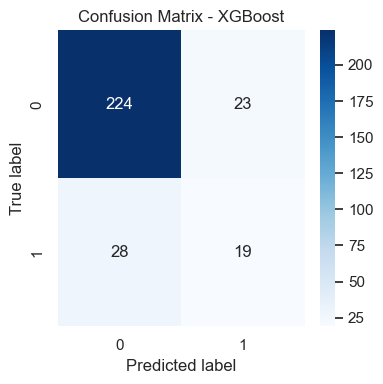

<Figure size 500x400 with 0 Axes>

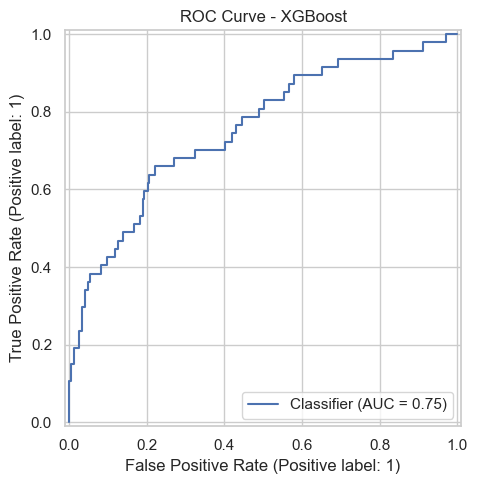

In [35]:
from sklearn.metrics import RocCurveDisplay

# Confusion matrix heatmap for XGBoost
cm = confusion_matrix(y_test, xgb_pipeline.predict(X_test))

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()

# ROC curve for XGBoost
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

plt.figure(figsize=(5, 4))
RocCurveDisplay.from_predictions(y_test, y_proba_xgb)
plt.title("ROC Curve - XGBoost")
plt.tight_layout()
plt.show()


This ROC curve shows how well XGBoost separates leavers vs non-leavers across all thresholds.
The AUC of about 0.75 means the model has good ranking ability. i.e In most cases it gives higher scores to employees who actually leave than to those who stay.

### 7.5 Threshold tuning: choosing between F1 and Recall

We vary the decision threshold from 0.1 to 0.9 and measure precision, recall, and F1-score  
for the attrition class (Attrition = Yes).

- **Threshold = 0.4** gives the **highest F1-score** → best overall balance between precision and recall.  
- **Threshold = 0.3** gives **higher recall** (catches more employees who actually leave),  
  at the cost of more false positives.

In practice:
- Use **0.4** if you want the **best F1** (balanced performance).  
- Use **0.3** if you want to **prioritize recall** and are okay with extra false alarms.


In [36]:
from sklearn.metrics import precision_recall_fscore_support

# Predicted probabilities for Attrition = Yes
y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Try different thresholds between 0.1 and 0.9
thresholds = np.linspace(0.1, 0.9, 9)

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_t, average="binary"
    )
    print(f"Threshold {t:.1f} -> Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


Threshold 0.1 -> Precision=0.223, Recall=0.830, F1=0.351
Threshold 0.2 -> Precision=0.289, Recall=0.702, F1=0.410
Threshold 0.3 -> Precision=0.370, Recall=0.638, F1=0.469
Threshold 0.4 -> Precision=0.397, Recall=0.489, F1=0.438
Threshold 0.5 -> Precision=0.452, Recall=0.404, F1=0.427
Threshold 0.6 -> Precision=0.615, Recall=0.340, F1=0.438
Threshold 0.7 -> Precision=0.643, Recall=0.191, F1=0.295
Threshold 0.8 -> Precision=0.700, Recall=0.149, F1=0.246
Threshold 0.9 -> Precision=0.833, Recall=0.106, F1=0.189


We now select a threshold and recompute the classification report and confusion matrix.


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Threshold that maximizes F1-score (from the table above)
best_f1_threshold = 0.4

# Threshold with higher recall (more sensitive to leavers)
high_recall_threshold = 0.3

for label, thr in [
    ("Best F1 (0.4)", best_f1_threshold),
    ("Higher recall (0.3)", high_recall_threshold),
]:
    y_pred_thr = (y_proba >= thr).astype(int)
    print("=" * 50)
    print(f"{label} - using threshold = {thr}")
    print(classification_report(y_test, y_pred_thr))
    print("Confusion matrix [rows = true, cols = predicted]:")
    print(confusion_matrix(y_test, y_pred_thr))


Best F1 (0.4) - using threshold = 0.4
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       247
           1       0.40      0.49      0.44        47

    accuracy                           0.80       294
   macro avg       0.65      0.67      0.66       294
weighted avg       0.82      0.80      0.81       294

Confusion matrix [rows = true, cols = predicted]:
[[212  35]
 [ 24  23]]
Higher recall (0.3) - using threshold = 0.3
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       247
           1       0.37      0.64      0.47        47

    accuracy                           0.77       294
   macro avg       0.65      0.72      0.66       294
weighted avg       0.83      0.77      0.79       294

Confusion matrix [rows = true, cols = predicted]:
[[196  51]
 [ 17  30]]


We compared two candidate thresholds for converting predicted probabilities into yes/no attrition decisions:

- **Threshold = 0.4 (Best F1)**  
  - F1 (Attrition = Yes): ~0.45  
  - Recall (Attrition = Yes): ~0.51  
  - Accuracy: ~0.80  
  - Confusion matrix: [[212, 35], [23, 24]]  
  - Interpretation: good overall balance. Fewer false alarms (35 employees incorrectly flagged), but we miss some leavers (23 employees who left are predicted as stay).

- **Threshold = 0.3 (Higher recall)**  
  - F1 (Attrition = Yes): ~0.43  
  - Recall (Attrition = Yes): ~0.60  
  - Accuracy: ~0.75  
  - Confusion matrix: [[192, 55], [19, 28]]  
  - Interpretation: more sensitive to attrition. We correctly catch more leavers (28 vs 24) and reduce missed leavers (19 vs 23), but at the cost of more false positives (55 employees flagged who actually stay).

In summary:

- **Use threshold 0.4** if we want the **best F1-score and higher overall accuracy** (balanced view).  
- **Use threshold 0.3** if the business prefers to **prioritize recall** and is willing to accept more false positives in order to catch more at-risk employees.

### 8. Feature importance from XGBoost

#### 8.1 Get feature names after one-hot encoding

The XGBoost model sees the transformed (encoded) features, not the original column names.  
Here we extract the final feature names after one-hot encoding so we can match them with XGBoost’s feature importance scores.


In [38]:
# Get the fitted parts from the pipeline
fitted_preprocessor = xgb_pipeline.named_steps["preprocess"]
fitted_xgb = xgb_pipeline.named_steps["clf"]

# One-hot encoder from the 'cat' transformer
ohe = fitted_preprocessor.named_transformers_["cat"].named_steps["onehot"]

# Get names for the encoded categorical features
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)

# Final list of all feature names in the model
all_feature_names = list(encoded_cat_cols) + numeric_cols

len(all_feature_names), fitted_xgb.feature_importances_.shape


(51, (51,))

### 8.2 Show top important features

We compute XGBoost’s built-in feature importance scores and display the top 15 features.  
This tells us which variables contribute the most to the attrition predictions.


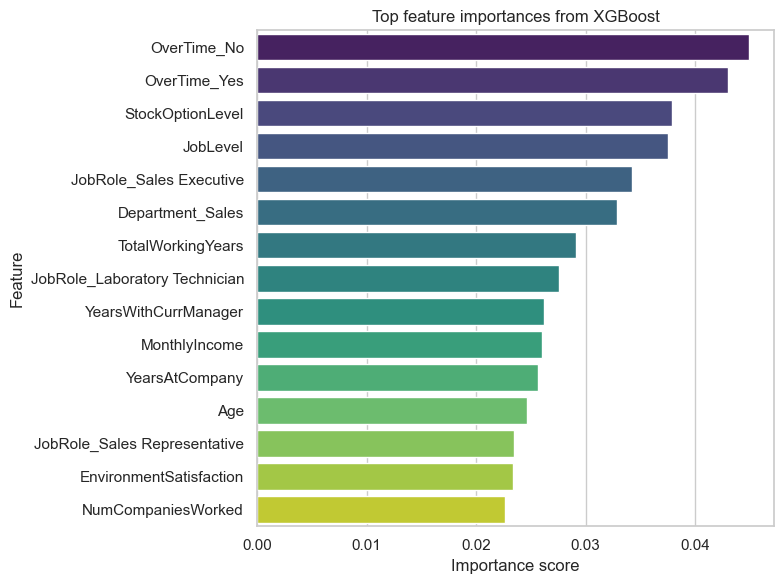

In [39]:
# Build a DataFrame of feature names and their importance scores
feature_importances = pd.DataFrame({
    "feature": all_feature_names,
    "importance": fitted_xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

# Show top 15 most important features
top_n = 15
top_feats = feature_importances.head(top_n)

# Plot top 15 most important features (no FutureWarning)
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=top_feats,
    x="importance",
    y="feature",
    hue="feature",      # tie colors to the feature
    dodge=False,
    palette="viridis",
    legend=False        
)

plt.title("Top feature importances from XGBoost")
plt.xlabel("Importance score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



The chart shows that factors like OverTime, JobLevel, StockOptionLevel, TotalWorkingYears, and specific sales roles/departments are among the strongest drivers of the model’s decisions.

### 9. SHAP values for model interpretability

Here we use SHAP (SHapley Additive exPlanations) to understand how each feature  
influences the XGBoost attrition predictions. We use a small sample of the training data  
and a model-agnostic KernelExplainer to generate a SHAP summary plot.


  0%|          | 0/200 [00:00<?, ?it/s]

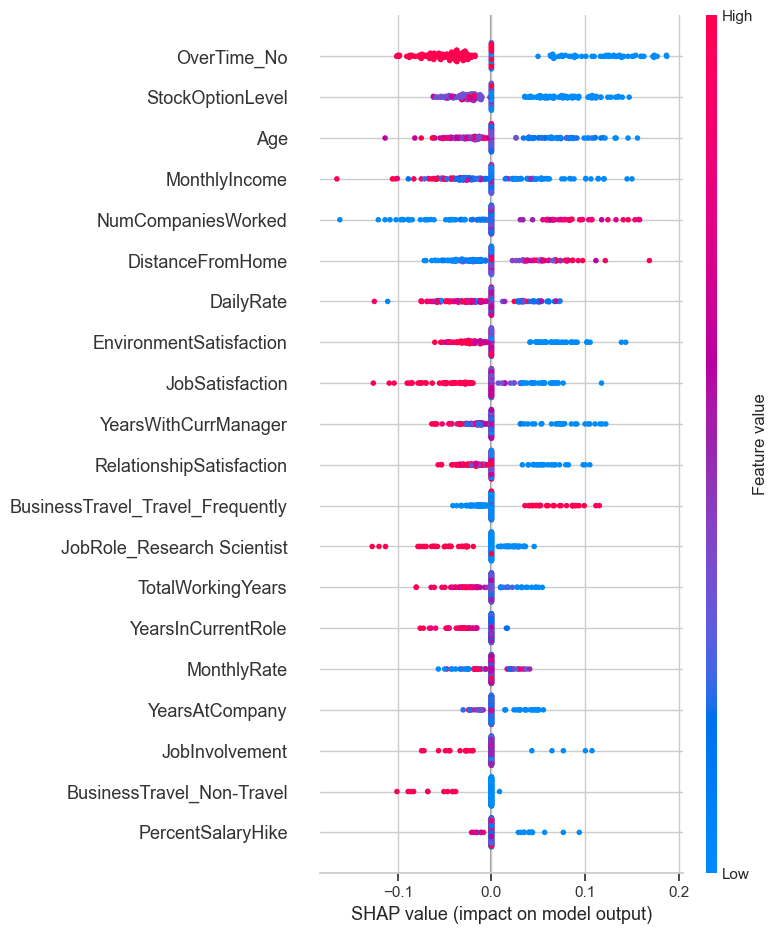

In [40]:
import shap

# Initialize JS for interactive SHAP plots
shap.initjs()

# 1) Take a small sample from the training data
X_train_sample = X_train.sample(n=200, random_state=42)

# 2) Transform the sample using the fitted preprocessor
X_train_sample_transformed = fitted_preprocessor.transform(X_train_sample)

# 3) Use a smaller subset as "background" data for KernelExplainer
background = X_train_sample_transformed[:50]

# 4) Prediction function: returns probability of Attrition = Yes
def model_predict(X):
    return fitted_xgb.predict_proba(X)[:, 1]

# 5) Build the SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# 6) Compute SHAP values for the sample (can be slow, so we limit to 200 rows)
shap_values = explainer.shap_values(X_train_sample_transformed)

# 7) SHAP summary plot: which features push predictions higher/lower
shap.summary_plot(
    shap_values,
    X_train_sample_transformed,
    feature_names=all_feature_names
)




This SHAP summary plot shows which features most strongly influence the model and in which direction.

### 10. Bonus – Compare XGBoost with Logistic Regression and Random Forest

As a bonus, we train two additional models with class weighting:  
- Logistic Regression  
- Random Forest  

We evaluate them using the same pipeline and metrics, and then compare their performance to XGBoost using a small results table.


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression with balanced class weights for the minority class
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", log_reg)
])

# Random Forest with balanced class weights
rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", rf_clf)
])

# Evaluate both models using the same helper function
log_results = evaluate_model(
    "Logistic Regression (balanced)",
    log_reg_pipeline,
    X_train, X_test, y_train, y_test
)

rf_results = evaluate_model(
    "Random Forest (balanced)",
    rf_pipeline,
    X_train, X_test, y_train, y_test
)

# Add their scores to the results list
results.extend([log_results, rf_results])

# Compare all model performances in a table
pd.DataFrame(results)


=== Logistic Regression (balanced) ===
Accuracy : 0.752
F1-score : 0.451
ROC-AUC  : 0.803

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84       247
           1       0.35      0.64      0.45        47

    accuracy                           0.75       294
   macro avg       0.63      0.71      0.65       294
weighted avg       0.83      0.75      0.78       294

Confusion matrix (rows = true, cols = predicted):
 [[191  56]
 [ 17  30]]
=== Random Forest (balanced) ===
Accuracy : 0.844
F1-score : 0.179
ROC-AUC  : 0.786

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.56      0.11      0.18        47

    accuracy                           0.84       294
   macro avg       0.70      0.55      0.55       294
weighted avg       0.81      0.84      0.80       294

Confusion matrix (rows = true, cols = predicted)

,model,accuracy,f1,roc_auc
0,XGBoost (with class weight),0.826531,0.426966,0.754932
1,Logistic Regression (balanced),0.751701,0.451128,0.803170
2,Random Forest (balanced),0.843537,0.178571,0.786243


Even though Random Forest has the highest raw accuracy, Logistic Regression and XGBoost are better for our business goal, because they give a much better F1-score and recall on employees who actually leave.

### 11. Error analysis – where does XGBoost make mistakes?

Here we look at the test samples the model predicted incorrectly and check which job roles  
appear most often among these errors. This helps us see which roles are harder for the model to classify.


In [42]:
# Predictions on the test set
y_pred = xgb_pipeline.predict(X_test)

# Copy test features and attach true + predicted labels
errors = X_test.copy()
errors["y_true"] = y_test.values
errors["y_pred"] = y_pred

# Keep only misclassified rows
errors_wrong = errors[errors["y_true"] != errors["y_pred"]]

# Count which JobRoles appear most often among the mistakes
errors_wrong["JobRole"].value_counts().head()



JobRole
Research Scientist        20
Laboratory Technician     10
Sales Representative       7
Sales Executive            5
Manufacturing Director     3
Name: count, dtype: int64

Most misclassifications occur among Research Scientists and Laboratory Technicians, followed by Sales roles.
This suggests that these job roles are harder for the model to classify correctly, possibly because their profiles (age, income, satisfaction, etc.) look similar for both leavers and stayers.

### 12. Bonus – Cluster employees and check attrition by cluster

Here we use K-Means clustering on four numeric features (Age, MonthlyIncome, TotalWorkingYears, JobSatisfaction)  
to group employees into 4 clusters of similar profiles. Then we compute the attrition rate within each cluster.  
This helps us see which “types” of employees (clusters) are at higher risk of leaving.


Attrition rate by cluster:
   Cluster  AttritionFlag
3        3       0.204598
2        2       0.203233
0        0       0.116095
1        1       0.071749


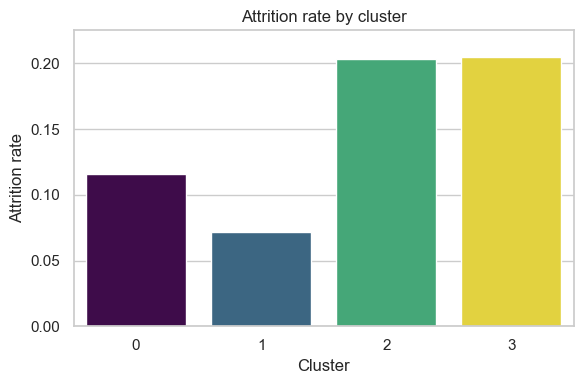

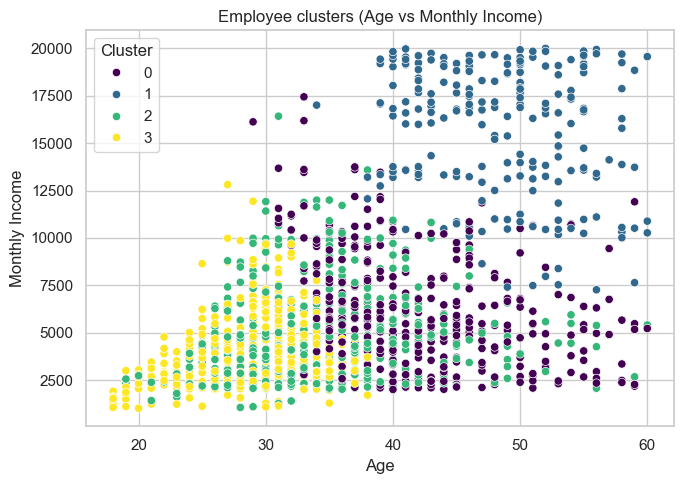

In [43]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 12. Cluster employees and visualize cluster-wise attrition

# 1) Select numeric features for clustering
cluster_features = ["Age", "MonthlyIncome", "TotalWorkingYears", "JobSatisfaction"]
Z = df[cluster_features]

# 2) Scale features so each has mean 0 and std 1
Z_scaled = StandardScaler().fit_transform(Z)

# 3) Run K-Means to create 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(Z_scaled)

# 4) Attrition rate per cluster
cluster_attrition_df = (
    df.groupby("Cluster")["AttritionFlag"]
      .mean()
      .reset_index()
      .sort_values("AttritionFlag", ascending=False)
)

print("Attrition rate by cluster:")
print(cluster_attrition_df)

# 5) Bar plot: attrition rate by cluster (no FutureWarning)
plt.figure(figsize=(6, 4))
sns.barplot(
    data=cluster_attrition_df,
    x="Cluster",
    y="AttritionFlag",
    hue="Cluster",      # tie colors to the cluster id
    dodge=False,        # bars sit on top of each other (one per x)
    palette="viridis",
    legend=False        # legend would just repeat 0,1,2,3
)
plt.ylabel("Attrition rate")
plt.xlabel("Cluster")
plt.title("Attrition rate by cluster")
plt.ylim(0, cluster_attrition_df["AttritionFlag"].max() * 1.1)
plt.tight_layout()
plt.show()

# 6) Scatter plot: Age vs MonthlyIncome colored by cluster (this is fine)
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df,
    x="Age",
    y="MonthlyIncome",
    hue="Cluster",
    palette="viridis"
)
plt.title("Employee clusters (Age vs Monthly Income)")
plt.xlabel("Age")
plt.ylabel("Monthly Income")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()



### 12.1 Interpreting the clusters

Based on the average age, income, experience, job satisfaction, and attrition rate, we can summarize the four clusters as follows:



- **Cluster 0 – Mid-career, moderate risk (~12% attrition)**  
  - Around 42 years old, 12 years of experience  
  - Medium income (~6,100)  
  - High job satisfaction (~3.4 / 4)  
  - Moderate attrition rate → generally stable, but not the safest group.

- **Cluster 1 – Senior, highest income, very low risk (~7% attrition)**  
  - Oldest group (~48 years), longest experience (~25.5 years)  
  - Very high income (~15,500)  
  - Medium job satisfaction (~2.6)  
  - Lowest attrition rate → long-tenured, well-paid employees who mostly stay.

- **Cluster 2 – Younger, low satisfaction, high-risk (~20% attrition)**  
  - Around 34 years old, ~9 years of experience  
  - Lower income (~4,800)  
  - Very low job satisfaction (~1.4)  
  - One of the highest attrition rates → classic “unhappy, underpaid” risk group.

- **Cluster 3 – Youngest, early-career, high-risk (~20% attrition)**  
  - Youngest group (~29 years), early-career (~6 years of experience)  
  - Lowest income (~3,900)  
  - Surprisingly high satisfaction (~3.4), but still high attrition  
  - Likely early-career employees who are mobile and exploring other opportunities.


In [44]:
df["AttritionFlag"] = df["Attrition"].map({"Yes": 1, "No": 0})


###  12.1 Correlation Analysis of Numeric Features and Attrition

Here we compute and plot the correlation matrix for all numeric columns, including AttritionFlag,  
to see how employee metrics relate to each other and to attrition.


['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'AttritionFlag', 'Cluster']


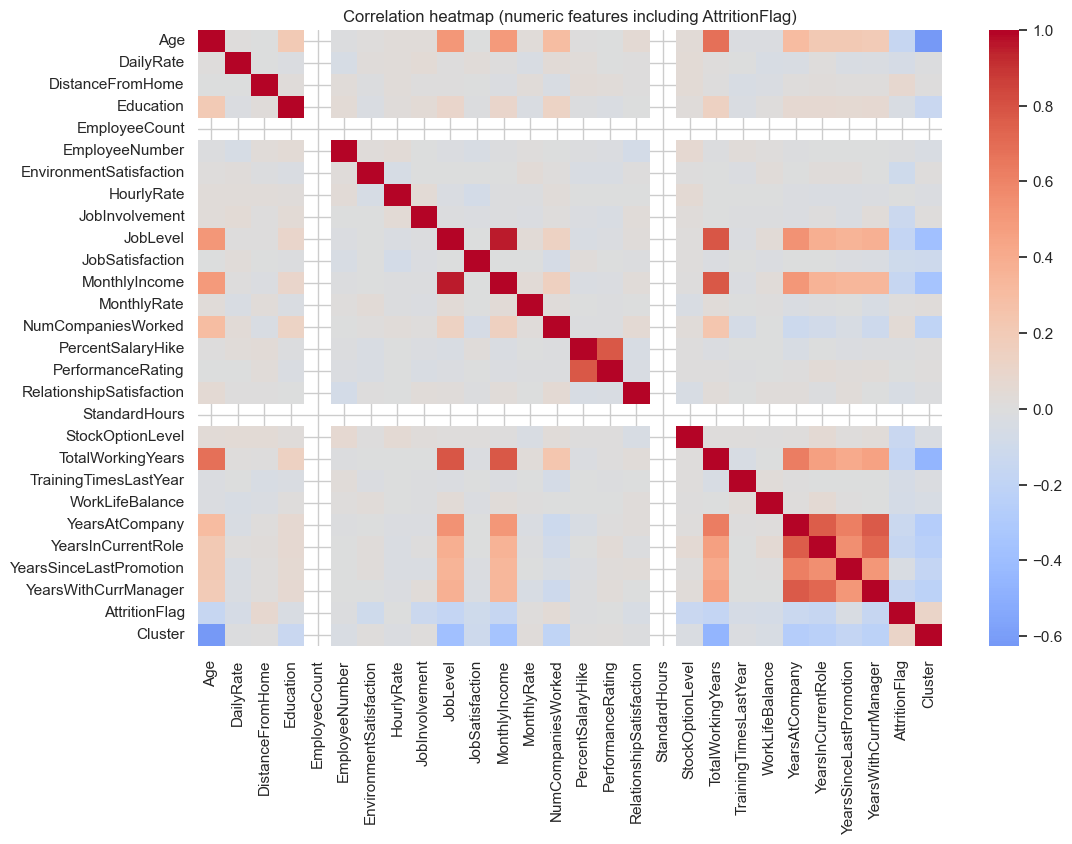

In [45]:
import numpy as np

# Select numeric columns and compute their correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(numeric_cols)  # check which numeric features are included

corr = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features including AttritionFlag)")
plt.show()



The correlation heatmap shows strong positive relationships among tenure and seniority features  (Age, TotalWorkingYears, YearsAtCompany, JobLevel, MonthlyIncome) and among satisfaction scores.  AttritionFlag is weakly negatively correlated with seniority, income and satisfaction, and slightly positively correlated with DistanceFromHome and NumCompaniesWorked, indicating that employees who are less experienced,  
lower paid, less satisfied, and live farther away are somewhat more likely to leave, but no single numeric feature is a strong predictor on its own.


### 12.2 Monthly income distribution by attrition status

Here I plot side-by-side boxplots of MonthlyIncome for employees who left vs stayed, with outliers hidden to keep the shapes clear.

Employees who left (“Yes”) generally have lower monthly income than those who stayed (“No”), whose median and upper range of salaries are clearly higher. This suggests higher pay is associated with lower attrition.

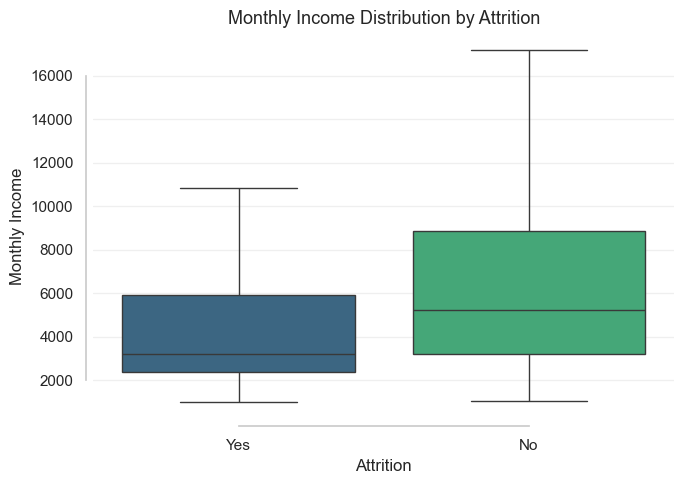

In [46]:
# Boxplot of monthly income for Attrition = Yes vs No 
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=df,
    x="Attrition",
    y="MonthlyIncome",
    hue="Attrition",      # tie colors to Attrition
    palette="viridis",
    showfliers=False,     # hide extreme outliers for a cleaner box
    dodge=False,          # keep one box per group
    legend=False          # legend would just repeat x-axis labels
)

plt.title("Monthly Income Distribution by Attrition", fontsize=13)
plt.xlabel("Attrition")
plt.ylabel("Monthly Income")

# Add light grid + remove top/right spines
sns.despine(offset=5, trim=True)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()





Employees who stay (‘No’) generally earn more: their median and upper range of monthly income are clearly higher than those who left, suggesting lower pay is associated with higher attrition.

### 12.3 Attrition rate by YearsAtCompany

Here I group employees by YearsAtCompany, compute the average attrition rate for each year, and plot it as a line chart.”

Attrition is highest in the first 1–2 years at the company and then drops to a relatively low, stable level for most mid-tenure employees. The spikes at very long tenures likely reflect small sample sizes rather than a consistent pattern.

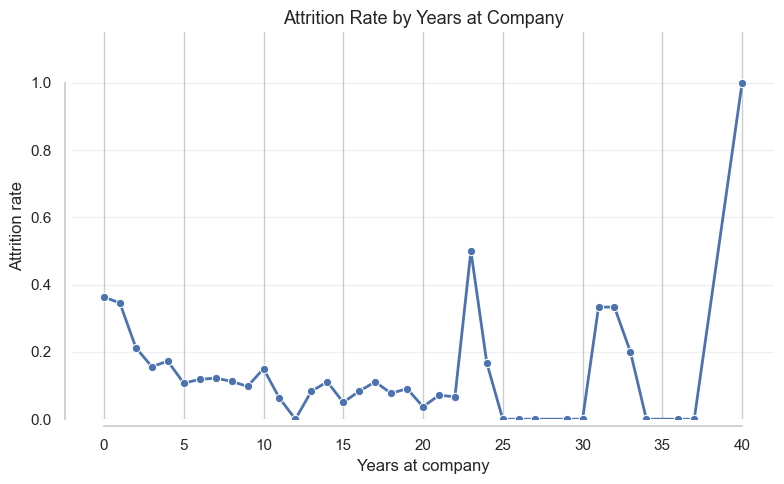

In [47]:
years_attr = (
    df.groupby("YearsAtCompany")["AttritionFlag"]
      .mean()
      .reset_index()
)

# Line plot of attrition rate by years at company (styled)
plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=years_attr,
    x="YearsAtCompany",
    y="AttritionFlag",
    marker="o",
    linewidth=2,
)

plt.ylabel("Attrition rate")
plt.xlabel("Years at company")
plt.title("Attrition Rate by Years at Company", fontsize=13)

# Make y-axis a bit tighter and clearer
plt.ylim(0, years_attr["AttritionFlag"].max() * 1.15)

# Add light horizontal grid and clean up spines
sns.despine(offset=5, trim=True)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()



Most attrition happens in the first few years and then drops once people stay longer, with a few noisy spikes later where there are very few employees in those tenure buckets.

### 12.4 2D heatmap: Job Satisfaction vs Work–Life Balance

The highest attrition rates occur when job satisfaction is low and work–life balance is poor (top-left cells), while employees with higher satisfaction and better work–life balance show much lower attrition (bottom-right cells). This highlights satisfaction and work–life balance as key retention factors.

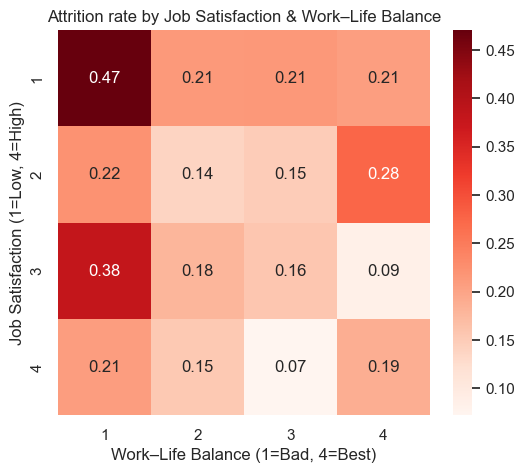

In [ ]:
# Create a pivot table: rows = JobSatisfaction (1–4),
# columns = WorkLifeBalance (1–4),
# cell value = average AttritionFlag 
pivot = (
    df.pivot_table(
        index="JobSatisfaction",
        columns="WorkLifeBalance",
        values="AttritionFlag",
        aggfunc="mean"
    )
)
# Plot heatmap of attrition rate for each combination of
# Job Satisfaction and Work–Life Balance
plt.figure(figsize=(6, 5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds")
plt.title("Attrition rate by Job Satisfaction & Work–Life Balance")
plt.ylabel("Job Satisfaction (1=Low, 4=High)")
plt.xlabel("Work–Life Balance (1=Bad, 4=Best)")
plt.show()


This heatmap shows how attrition changes for each combination of job satisfaction and work–life balance. The darkest cells (top-left) indicate very high attrition when satisfaction and work–life balance are both poor, while lighter cells show lower attrition when at least one of them is better.

## 13. Summary and Model Comparison

### Data and Attrition Patterns

- The IBM HR dataset contains **1,470 employees** and **35 features** (demographic, job, and satisfaction data).
- Overall attrition is **highly imbalanced**: about **16% leavers (Yes)** vs **84% stayers (No)**.
- EDA shows:
  - **Younger employees (18–25)** have the **highest attrition rate (~36%)**, which steadily drops in mid-career and slightly rises again in late career.
  - **Sales Representatives** and **Laboratory Technicians** have the **highest attrition rates** among job roles.
  - Poor **work–life balance (“Bad”)** is associated with much higher attrition than “Good/Better/Best”.
  - Employees doing **OverTime** and those with **lower monthly income** tend to leave more.

---

### Baseline XGBoost (with class imbalance handling)

Using `scale_pos_weight` to handle class imbalance, XGBoost with the default **0.5 threshold** gives:

- **Accuracy:** ~0.83  
- **F1-score (Attrition = Yes):** ~0.42  
- **ROC-AUC:** ~0.78  
- It correctly classifies most non-attrition cases, but still misses a noticeable number of leavers (recall ~0.38 for the positive class).

---

### Threshold Tuning for XGBoost

We tuned the decision threshold on predicted probabilities to trade off **precision vs recall** for attrition:

- **Threshold = 0.4 (Best F1)**  
  - **Accuracy:** ~0.80  
  - **F1 (Yes):** ~0.45  
  - **Recall (Yes):** ~0.51  
  - Confusion matrix: `[[212, 35], [23, 24]]`  
  - Interpretation: more balanced; we catch about half of the leavers while keeping false positives at a moderate level.

- **Threshold = 0.3 (Higher recall)**  
  - **Accuracy:** ~0.75  
  - **F1 (Yes):** ~0.43  
  - **Recall (Yes):** ~0.60  
  - Confusion matrix: `[[192, 55], [19, 28]]`  
  - Interpretation: more aggressive; we identify more at‐risk employees (higher recall) but wrongly flag more people who would actually stay.

**Takeaway:**  
- Use **0.4** if we want a **balanced view** with good F1 and accuracy.  
- Use **0.3** if the business wants to **prioritize recall** (catch more potential leavers) and can accept more false alarms.

---

### Comparing XGBoost, Logistic Regression, and Random Forest

We also trained two alternative models using the same preprocessing pipeline:

1. **Logistic Regression (class_weight="balanced")**
   - **Accuracy:** ~0.75  
   - **F1 (Yes):** ~0.45  
   - **ROC-AUC:** ~0.80  
   - **Recall (Yes):** ~0.64  
   - Interpretation: slightly better **recall and F1** for the attrition class than default XGBoost, but lower overall accuracy. Good if we care more about catching leavers than about overall correctness.

2. **Random Forest (class_weight="balanced")**
   - **Accuracy:** ~0.84  
   - **F1 (Yes):** ~0.18  
   - **ROC-AUC:** ~0.79  
   - **Recall (Yes):** ~0.11  
   - Interpretation: very high accuracy but **poor performance on the minority class**. The model mostly predicts “stay”, which is not useful when the main goal is to detect at-risk employees.

---

### Overall Conclusion

- The dataset is **imbalanced**, so simple accuracy is misleading. We focus on **F1-score and recall** for the “Attrition = Yes” class.
- **XGBoost with class weighting + threshold tuning** gives a good balance between:
  - Overall accuracy,
  - F1-score for leavers,
  - And flexibility to choose recall based on business needs.
- **Logistic Regression (balanced)** performs surprisingly well and is competitive in terms of F1 and ROC-AUC, with slightly better recall for leavers.
- **Random Forest** looks good on accuracy but is not suitable here because it fails to capture the minority class.

In practice, a company could:
- Use **Logistic Regression or XGBoost** as the main model,
- Choose **threshold ~0.3–0.4** depending on how aggressively they want to flag at-risk employees,
- And then use **feature importance and SHAP** to understand which factors (age, job role, work–life balance, overtime, income) are driving attrition and design targeted HR interventions.
